In [145]:
import sys
sys.path.append("/volatile/aurelien_stumpf_mascles/project/code")

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R

In [147]:
import importlib
importlib.reload(package.torch_classifier)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.model)

<module 'cebra_v2.model' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/model.py'>

## Data Loading

In [148]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

KeyboardInterrupt: 

In [ ]:
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc_all = dfc[meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_session = dfc_all.reshape((-1,464,1,82,82))

## Conv Network Training

In [ ]:
dict_labels = {"light-propofol" : 0, "deep-propofol" : 1, "awake" : 2}

In [ ]:
labels_condition = meta["condition"].loc[meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol'])]
labels = np.array([dict_labels[elem] for elem in labels_condition]).reshape((len(labels_condition)//464,464))

In [ ]:
seed = 5

In [ ]:
net = package.torch_classifier.CNN1()
a,b,_,_ = dfc_all.shape
sessions_class = np.array([labels[session,0] for session in range(labels.shape[0])])
idx_sessions = np.arange(labels.shape[0])
dfc_sessions = dfc_all.reshape(-1,464,1,82,82)

idx_train,idx_else,sessions_train,sessions_else = train_test_split(idx_sessions, sessions_class, test_size=0.5, random_state=seed, stratify = sessions_class)
idx_test, idx_val, sessions_test, sessions_val = train_test_split(idx_else, sessions_else, test_size=0.5, random_state=seed, stratify = sessions_else)
X_train = dfc_sessions[idx_train,:,:].reshape(-1,1,82,82)
y_train = labels[idx_train,:].reshape(-1)
X_test = dfc_sessions[idx_test,:,:].reshape(-1,1,82,82)
y_test = labels[idx_test,:].reshape(-1)
X_val = dfc_sessions[idx_val,:,:].reshape(-1,1,82,82)
y_val = labels[idx_val,:].reshape(-1)

train = package.torch_classifier.SimpleDataset(X_train,y_train)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 3, n_samples = 200)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True, num_workers=6)

In [ ]:
package.torch_classifier.Train(net,train_loader,test_loader,100,lr = 0.01)

Train loss 1.0920, Train accuracy 34.89%
Test accuracy 44.00%
Train loss 0.2164, Train accuracy 91.10%
Test accuracy 75.61%


KeyboardInterrupt: 

## Grad CAM

In [ ]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [ ]:
backward_hook = net.fc2.register_full_backward_hook(backward_hook, prepend=False)
forward_hook = net.fc2.register_forward_hook(forward_hook, prepend=False)

In [179]:
img_tensor = torch.from_numpy(dfc_sessions[42,70,:,:,:]).unsqueeze(0).type(torch.float32)
label = labels[42,70]

In [180]:
net.eval()
pred = net(img_tensor)
pred.backward(torch.ones((1,3)))

Forward hook running...
Activations size: torch.Size([1, 5, 76, 76])
Backward hook running...
Gradients size: torch.Size([1, 5, 76, 76])


In [181]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

(-0.5, 75.5, 75.5, -0.5)

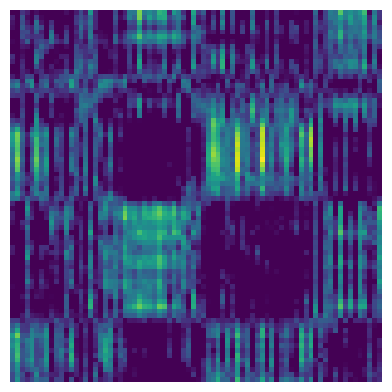

In [182]:
# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach())
plt.axis("off")

tensor([[7.9166e-01, 9.5247e-05, 2.0825e-01]], grad_fn=<ExpBackward0>)
0


(-0.5, 81.5, 81.5, -0.5)

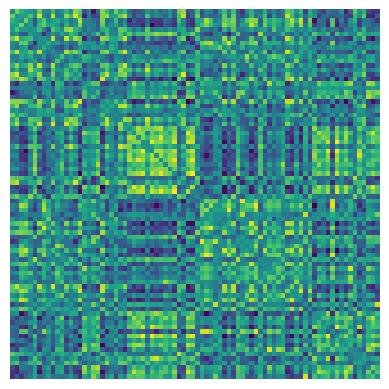

In [183]:
print(torch.exp(pred))
print(label)
plt.imshow(img_tensor.squeeze(0).squeeze(0))
plt.axis("off")

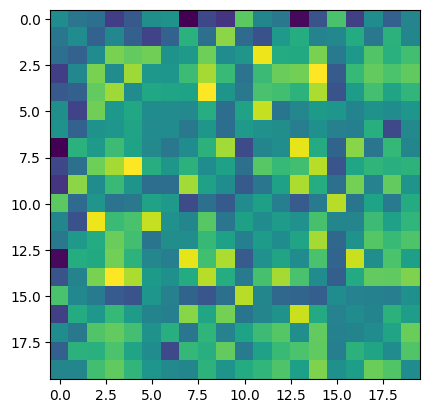

In [169]:
plt.imshow(img_tensor[0,0,40:60,40:60])

In [170]:
torch.mean(img_tensor[0,0,40:60,40:60])

tensor(0.0764)

In [173]:
torch.sum(img_tensor[0,0,20:40,40:70] < -0.5)

tensor(23)

In [ ]:
filter_maps = net.fc1.weight.detach().numpy()

## Validation

In [ ]:
forward_hook.remove()
backward_hook.remove()

In [ ]:
valid_loader = package.torch_classifier.SimpleDataset(X_val,y_val)

In [ ]:
idx_val[12]

42

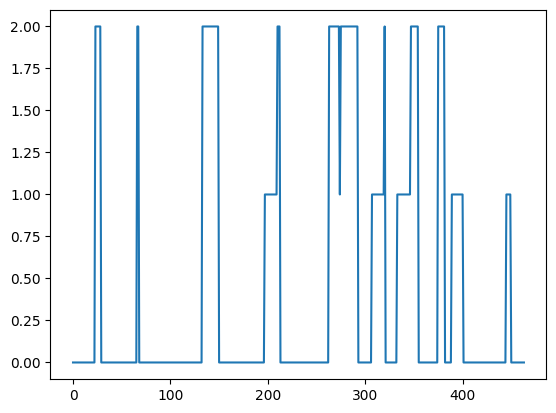

In [ ]:
dfc_session = dfc_all.reshape((-1,464,1,82,82))
data = torch.from_numpy(dfc_session[idx_val[12],:,:].reshape(-1,1,82,82))
probas = torch.exp(net(data.type(torch.float32)))
res = torch.argmax(probas,dim = 1)
plt.plot(res)

In [ ]:
net.eval()

# loop, over whole test set
compteur_batch = 0
net.eval()
test_correct = 0

for i, (batch,target) in enumerate(valid_loader):
    output = net(batch.unsqueeze(0))
    pred = output.max(1, keepdim=True)[1]
    test_correct += pred[0,0].eq(target).sum().item()
    compteur_batch+=1
    
print('Test accuracy {:.2f}%'.format(
    100 * test_correct / (compteur_batch)))

Test accuracy 74.56%


In [ ]:
net.eval()

# loop, over whole test set
compteur_batch = 0
net.eval()
test_correct = 0
p_light = 0
p_deep = 0
p_awake = 0

N_light = np.sum(y_val == 0)
for i, (batch,target) in enumerate(valid_loader):
    output = net(batch.unsqueeze(0))
    pred = output.max(1, keepdim=True)[1]
    p_light += pred[0,0].eq(0).sum().item() * (target == 0)
    p_deep += pred[0,0].eq(1).sum().item() * (target == 0)
    p_awake += pred[0,0].eq(2).sum().item() * (target == 0)
print(N_light)
print(100 * p_light / N_light , 100 * p_deep / N_light , 100 * p_awake / N_light)

test_correct = 0
p_light = 0
p_deep = 0
p_awake = 0
N_deep = np.sum(y_val == 1)
for i, (batch,target) in enumerate(valid_loader):
    output = net(batch.unsqueeze(0))
    pred = output.max(1, keepdim=True)[1]
    p_light += pred[0,0].eq(0).sum().item() * (target == 1)
    p_deep += pred[0,0].eq(1).sum().item() * (target == 1)
    p_awake += pred[0,0].eq(2).sum().item() * (target == 1)
print(N_deep)
print(100 * p_light / N_deep , 100 * p_deep / N_deep , 100 * p_awake / N_deep)

test_correct = 0
p_light = 0
p_deep = 0
p_awake = 0
N_awake = np.sum(y_val == 2)
for i, (batch,target) in enumerate(valid_loader):
    output = net(batch.unsqueeze(0))
    pred = output.max(1, keepdim=True)[1]
    p_light += pred[0,0].eq(0).sum().item() * (target == 2)
    p_deep += pred[0,0].eq(1).sum().item() * (target == 2)
    p_awake += pred[0,0].eq(2).sum().item() * (target == 2)
print(N_awake)
print(100 * p_light / N_awake , 100 * p_deep / N_awake , 100 * p_awake / N_awake)

2784
tensor(60.9914) tensor(37.2486) tensor(1.7601)
3712
tensor(30.7651) tensor(64.9784) tensor(4.2565)
3712
tensor(5.6034) tensor(3.2328) tensor(91.1638)


In [ ]:
dfc_session = dfc_all.reshape((-1,464,1,82,82))
for i in range(len(idx_val)):
    data = torch.from_numpy(dfc_session[idx_val[i],:,:].reshape(-1,1,82,82))
    accu = torch.exp(net(data.type(torch.float32)))
    probas = torch.sum(accu,dim = 0) / 464
    res = torch.argmax(probas)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels[idx_val[i],0],res,probas.detach().numpy()))

True label : 2, Predicted label : 2, Probas : [0.16138859 0.02641696 0.81219435]
True label : 0, Predicted label : 0, Probas : [6.7531478e-01 3.2427236e-01 4.1279441e-04]
True label : 1, Predicted label : 1, Probas : [0.18803467 0.69577575 0.11618964]
True label : 0, Predicted label : 0, Probas : [0.6566796  0.32620946 0.01711098]
True label : 1, Predicted label : 1, Probas : [0.12470073 0.80555844 0.06974083]
True label : 0, Predicted label : 0, Probas : [0.62741613 0.36585933 0.00672458]
True label : 2, Predicted label : 2, Probas : [0.06367463 0.09067718 0.8456482 ]
True label : 2, Predicted label : 2, Probas : [0.05468007 0.00948783 0.9358321 ]
True label : 1, Predicted label : 0, Probas : [0.5454908  0.41427764 0.04023158]
True label : 2, Predicted label : 2, Probas : [1.6345065e-02 5.0719449e-04 9.8314774e-01]
True label : 1, Predicted label : 1, Probas : [0.4522542  0.543913   0.00383283]
True label : 1, Predicted label : 1, Probas : [0.19531663 0.7937168  0.01096661]
True label

## Latent space

In [ ]:
#Run if you want the pretrained model
net = package.torch_classifier.CNN1()
net.load_state_dict(torch.load('/volatile/aurelien_stumpf_mascles/project/models/model_cnn.pth'))

<All keys matched successfully>

In [ ]:
embs = torch.zeros((dfc_session.shape[0],dfc_session.shape[1],3))
for i in range(dfc_session.shape[0]):
    print(i)
    data = torch.from_numpy(dfc_session[i,:,:].reshape(-1,1,82,82))
    accu = net(data.type(torch.float32))
    embs[i,:,:] = accu

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


/tmp/ipykernel_12478/2393589522.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(emb[i,:,2], emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels[i,0]], s=1)


(-0.935047858953476,
 1.0921386420726775,
 -1.0526256263256073,
 1.0977362096309662)

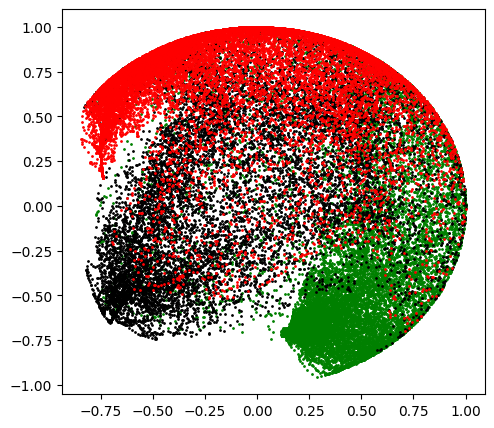

In [ ]:
fig = plt.figure(figsize = (12,5))

emb = torch.nn.functional.normalize(embs.detach() - embs.mean(dim = 0).mean(dim = 0).detach(),dim = -1).numpy()
ax1 = plt.subplot(121)
colors = ["black",'red','green']
for i in range(86):
    ax1.scatter(emb[i,:,2], emb[i,:,1], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')



In [ ]:
torch.save(net.state_dict(), '/volatile/aurelien_stumpf_mascles/project/models/model_cnn.pth')

In [ ]:
session_condition = [(i,meta["condition"].iloc[464*i],meta["monkey"].iloc[464*i]) for i in range(len(meta)//464)]

In [ ]:
session_condition

[(0, 'awake', 'almira'),
 (1, 'awake', 'almira'),
 (2, 'awake', 'almira'),
 (3, 'awake', 'almira'),
 (4, 'awake', 'jade'),
 (5, 'awake', 'jade'),
 (6, 'awake', 'jade'),
 (7, 'awake', 'jade'),
 (8, 'awake', 'jade'),
 (9, 'awake', 'jade'),
 (10, 'awake', 'jade'),
 (11, 'awake', 'jade'),
 (12, 'awake', 'jade'),
 (13, 'awake', 'jade'),
 (14, 'awake', 'jade'),
 (15, 'awake', 'jade'),
 (16, 'awake', 'jade'),
 (17, 'awake', 'jade'),
 (18, 'awake', 'jade'),
 (19, 'awake', 'jade'),
 (20, 'awake', 'jade'),
 (21, 'awake', 'jade'),
 (22, 'awake', 'khali'),
 (23, 'awake', 'khali'),
 (24, 'awake', 'khali'),
 (25, 'awake', 'khali'),
 (26, 'awake', 'khali'),
 (27, 'awake', 'khali'),
 (28, 'awake', 'khali'),
 (29, 'awake', 'khali'),
 (30, 'awake', 'khali'),
 (31, 'ketamine', 'khali'),
 (32, 'ketamine', 'khali'),
 (33, 'ketamine', 'khali'),
 (34, 'ketamine', 'khali'),
 (35, 'ketamine', 'khali'),
 (36, 'ketamine', 'khali'),
 (37, 'ketamine', 'khali'),
 (38, 'ketamine', 'khali'),
 (39, 'ketamine', 'kimiko

## STUDY

In [ ]:
print(np.sort(idx_val))

[ 1  7 11 13 19 24 27 29 34 35 41 45 49 50 70 71 72 74 77 82 83 85]


In [ ]:
net = package.torch_classifier.CNN1()
net.load_state_dict(torch.load('/volatile/aurelien_stumpf_mascles/project/models/model_cnn.pth'))

<All keys matched successfully>

In [ ]:
probas = torch.exp(embs)

In [ ]:
embs.shape

torch.Size([86, 464, 3])

In [ ]:
dfc_session = dfc_all.reshape((-1,464,1,82,82))
probas = torch.zeros((dfc_session.shape[0],dfc_session.shape[1],3))
for i in range(dfc_session.shape[0]):
    print(i)
    data = torch.from_numpy(dfc_session[i,:,:].reshape(-1,1,82,82))
    accu = torch.exp(net(data.type(torch.float32)))
    probas[i,:,:] = accu

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


KeyboardInterrupt: 

session 55 
 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]


[ 83 338  34  31 196 343  67 141 216 185 

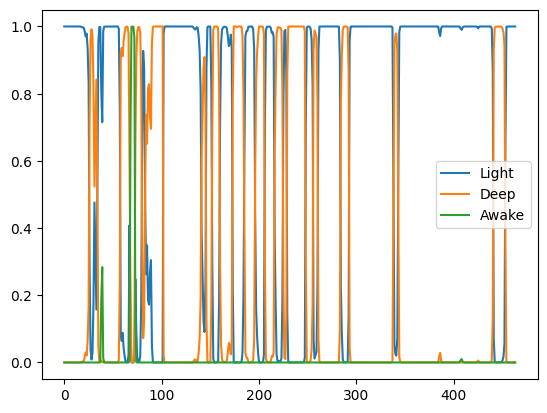

In [ ]:
session = 55
print("session {} \n \n".format(session))

li_preds = torch.argmax(probas[session,:,:],dim = 1)
print(li_preds.detach().numpy())
print("\n")

li = torch.max(probas[session,:,:],dim = 1).values
li_idx = torch.argsort(li)

print(li_idx.numpy()[:30])
print(li[li_idx].detach().numpy()[:30])

plt.plot(probas[session,:,:].detach().numpy(),label = ["Light","Deep","Awake"])
plt.legend()

In [ ]:
li = torch.exp(torch.max(probas[session,:,:],dim = 1).values)
li_idx = torch.argsort(li)[:30]
print("session {}".format(session))
print(li_idx.numpy())
print(li[li_idx].detach().numpy())


session 2
[294  57 244 295 405 188 326  58 317 241 184 177 290  56 180 354 179 187
 167 417 189 242 243 353 404  55 176 416 160 240]
[0.47856992 0.51642525 0.521175   0.5524581  0.55821854 0.56795853
 0.5715384  0.58622    0.60049486 0.60385686 0.61387575 0.62522584
 0.6268903  0.6287648  0.65682083 0.6581032  0.6683936  0.70173305
 0.7201702  0.7220686  0.7248022  0.72768086 0.7340977  0.740375
 0.7425484  0.75578964 0.7637748  0.77307713 0.7759503  0.7892672 ]


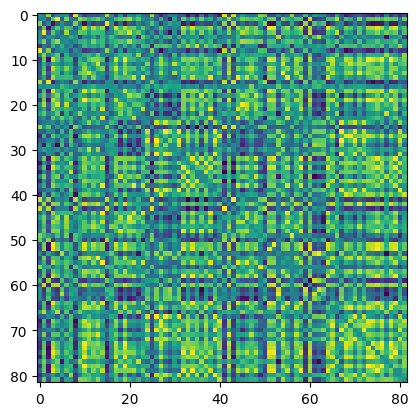

In [ ]:
plt.imshow(dfc_all[session,240,:,:])

## CEBRA tuning

In [ ]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)


In [ ]:
class Norm(nn.Module):

    def __init__(self,center = None):
        super(Norm,self).__init__()
        self.center = center
    
    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        if self.center is not None:
            return torch.nn.functional.normalize(inp - self.center)
        else : 
            return torch.nn.functional.normalize(inp - self.center)

model = nn.Sequential(package.torch_classifier.CNN1(),Norm(center = embs.mean(dim = 0).mean(dim = 0).detach()))
model[0].load_state_dict(torch.load('/volatile/aurelien_stumpf_mascles/project/models/model_cnn.pth'))

<All keys matched successfully>

In [ ]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(torch.from_numpy(dfc_session)) #,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 200,time_delta = 5)

In [ ]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-5, model = model)

In [ ]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 4.4682, Train accuracy 0.00%
Epoch 100
Train loss 4.4690, Train accuracy 0.00%
Epoch 200
Train loss 4.4625, Train accuracy 0.00%
Epoch 300
Train loss 4.4657, Train accuracy 0.00%
Epoch 400
Train loss 4.4690, Train accuracy 0.00%
Epoch 500
Train loss 4.4592, Train accuracy 0.00%


KeyboardInterrupt: 

/tmp/ipykernel_27741/1638361945.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(fc_emb[:,1], fc_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels[i,0]], s=1)


(-1.078243911266327,
 1.098857343196869,
 -1.0202237963676453,
 1.0961156487464905)

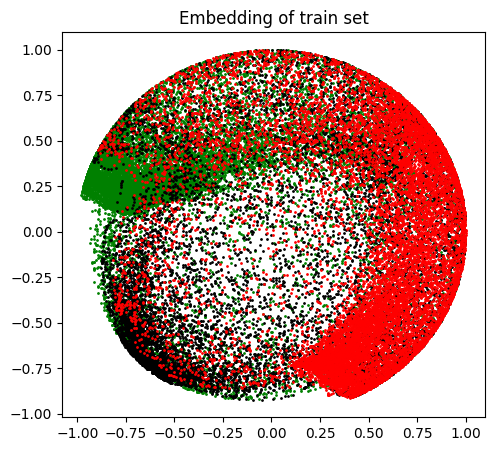

In [ ]:
fig = plt.figure(figsize = (12,5))

data = torch.from_numpy(dfc_session).type(torch.float32)
ax1 = plt.subplot(121)
ax1.set_title('Embedding of train set')
colors = ["black",'red','green']
for i in range(86):
    data = torch.from_numpy(dfc_session[i,:,:,:].reshape(-1,1,82,82)).type(torch.float32)
    fc_emb = model(data).detach().numpy()
    ax1.scatter(fc_emb[:,1], fc_emb[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

In [ ]:
embs.shape

torch.Size([86, 464, 3])

/tmp/ipykernel_27741/1660296960.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(embedding[i,:,0], embedding[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels[i,0]], s=1)


(-52.52454528808594,
 2.5011688232421876,
 -49.508955574035646,
 2.3575693130493165)

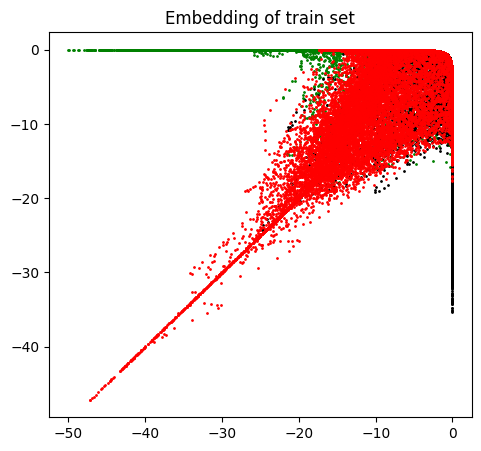

In [ ]:
fig = plt.figure(figsize = (12,5))

embedding = embs.detach().numpy()
ax1 = plt.subplot(121)
ax1.set_title('Embedding of train set')
colors = ["black",'red','green']
for i in range(86):
    ax1.scatter(embedding[i,:,0], embedding[i,:,2], cmap = matplotlib.colors.ListedColormap(colors), c = colors[labels[i,0]], s=1)
#ax1.xticks() 
ax1.axis('on')

In [ ]:
embedding.shape

(86, 464, 3)

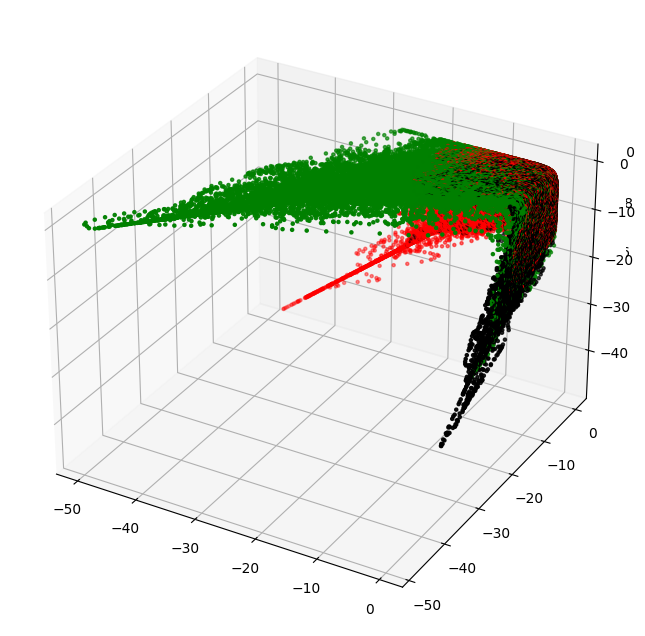

In [ ]:

from mpl_toolkits import mplot3d
from scipy import signal
 
# Creating 3D figure
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
 
# Creating Dataset
t = np.linspace(0, 1, 1000, endpoint = True)
ax = fig.add_subplot(projection='3d')
colors = ["black",'red','green']
points = embedding.reshape(-1,3)
ax.scatter(points[:,0], points[:,1], points[:,2], cmap = matplotlib.colors.ListedColormap(colors), marker='.', c = labels)
 
plt.show()